In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
df = pd.read_csv('~/Downloads/amazon_reviews_us_Watches_v1_00.tsv', 
                 delimiter='\t',
                 error_bad_lines=False)

b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkipping line 197432: expected 15 fields, saw 22\nSkipping line 208016: expected 15 fields, saw 22\nSkipping line 214110: expected 15 fields, saw 22\nSkipping line 244328: expected 15 fields, saw 22\nSkipping line 248519: expected 15 fields,

In [3]:
# sample top of the dataset
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [4]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,9.602040e+05,9.602040e+05,960204.000000,960204.000000,960204.000000
mean,2.600101e+07,5.060448e+08,4.138161,1.197180,1.561571
std,1.581616e+07,2.864151e+08,1.293327,8.163426,9.071388
min,1.001600e+04,4.384000e+03,1.000000,0.000000,0.000000
25%,1.280548e+07,2.588358e+08,4.000000,0.000000,0.000000
50%,2.396748e+07,5.166657e+08,5.000000,0.000000,0.000000
75%,4.108624e+07,7.491827e+08,5.000000,1.000000,1.000000
max,5.309646e+07,9.999979e+08,5.000000,4004.000000,4249.000000


In [5]:
print('Unique Customers: {}'.format(len(df.customer_id.unique())))
print('Unique Products: {}'.format(len(df.product_id.unique())))

Unique Customers: 719522
Unique Products: 149658


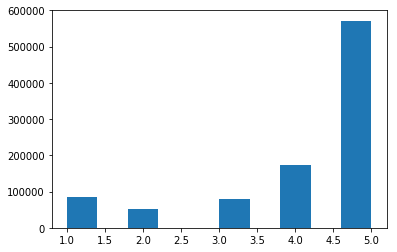

In [6]:
# distribution of stars ratings in reviews
plt.hist(df.star_rating)
plt.show()

In [7]:
# top star_rating with no filter
df.groupby('product_id').agg(['mean', 'count']).sort_values([('star_rating', 'mean')], ascending=False).head(10)

customer_id       product_parent       star_rating        \
                  mean count           mean count        mean count   
product_id                                                            
1380137136  51483206.0     1    518987366.0     1         5.0     1   
B007K1PCIW  16660137.0     1    978864006.0     1         5.0     1   
B007K7EF5W   8478905.0     1    874242421.0     1         5.0     1   
B007K5B71Y  35689437.5     2    241411351.0     2         5.0     2   
B007K5B6Z6  33458367.0     1    621913171.0     1         5.0     1   
B007K5B3WM  45187237.0     1    786395679.0     1         5.0     1   
B007K5B3VS  17952767.0     1    874974768.0     1         5.0     1   
B007K44OWE   6537352.0     1     80314280.0     1         5.0     1   
B007K447YY  31932434.0     1    503003533.0     1         5.0     1   
B007JYU424  37287899.0     2    703415811.0     2         5.0     2   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
1380137136           0.0     1         0.0     1  
B007K1PCIW           0.0     1         0.0     1  
B007K7EF5W           0.0     1         0.0     1  
B007K5B71Y           0.0     2         0.0     2  
B007K5B6Z6           0.0     1         0.0     1  
B007K5B3WM           0.0     1         0.0     1  
B007K5B3VS           0.0     1         0.0     1  
B007K44OWE           0.0     1         0.0     1  
B007K447YY           0.0     1         0.0     1  
B007JYU424           0.0     2         0.0     2

In [8]:
# Review date range
min_review_date = pd.to_datetime(df.review_date).min()
max_review_date = pd.to_datetime(df.review_date).max()
"Reviews are from {} to {}".format(min_review_date, max_review_date)

'Reviews are from 2001-04-05 00:00:00 to 2015-08-31 00:00:00'

In [9]:
# Top Tier: Products that appear at the very top of rankings
top_tier_search_sources = [
    'fashion-mens-watches-pg1.html',
    'fashion-mens-watches-pg2.html',
    'fashion-mens-watches-pg3.html',
]

# High Tier: Products that appear between Top Tier and Mid Tier of rankings
high_tier_search_sources = [
    'fashion-mens-watches-pg100.html',
    'fashion-mens-watches-pg101.html',
    'fashion-mens-watches-pg102.html',
]

# Mid Tier: Products that appear at the middle of rankings
mid_tier_search_sources = [
    'fashion-mens-watches-pg200.html',
    'fashion-mens-watches-pg201.html',
    'fashion-mens-watches-pg202.html',
]

# Low Tier: Products that appear between Mid Tier and Bottom Tier of rankings
low_tier_search_sources = [
    'fashion-mens-watches-pg300.html',
    'fashion-mens-watches-pg301.html',
    'fashion-mens-watches-pg302.html',
]

# Bottom Tier: Products that appear at the bottom of rankings
bottom_tier_search_sources = [
    'fashion-mens-watches-pg398.html',
    'fashion-mens-watches-pg399.html',
    'fashion-mens-watches-pg400.html',
]

In [10]:
flatten = lambda l: [item for sublist in l for item in sublist]

def get_product_ids_from_html(filepath):
    """ Function reads search results html source and returns the Amazon product_ids found """
    with open(filepath, 'r') as content_file:
        content = content_file.read()

    soup = BeautifulSoup(content, 'html.parser')
    product_ids = []
    item_sections = soup.select('[data-component-type="s-search-results"] div[data-asin]')
    nonsponsored_item_sections = [item_section for item_section in item_sections 
                                  if str(item_section).find('Sponsored') < 0]
    product_ids = [item.get('data-asin') for item in nonsponsored_item_sections]
    return product_ids

def get_tier_product_ids(tier_search_sources):
    """ Returns product_ids from tier search sources """
    return flatten([get_product_ids_from_html(os.path.join('RankingData', x)) for x in tier_search_sources])

In [11]:
# Get product_ids for each tier
top_tier_product_ids = get_tier_product_ids(top_tier_search_sources)
high_tier_product_ids = get_tier_product_ids(high_tier_search_sources)
mid_tier_product_ids = get_tier_product_ids(mid_tier_search_sources)
low_tier_product_ids = get_tier_product_ids(low_tier_search_sources)
bottom_tier_product_ids = get_tier_product_ids(bottom_tier_search_sources)

In [12]:
# Display samples from top tier
top_tier_df = df[df.product_id.isin(top_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
top_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B00284ADAI  2.760133e+07   421      764247551   421    4.669834   421   
B00B7FXSPG  2.582647e+07    99      625413336    99    4.757576    99   
B001IBF15Y  2.536294e+07    62      926397333    62    4.532258    62   
B0088BN1V8  2.267112e+07    27      453322554    27    4.851852    27   
B00X6KVTVA  1.997972e+07     5      427652180     5    5.000000     5   
B005QH7S0M  2.759235e+07    20      280272688    20    4.750000    20   
B006ITF59I  2.185082e+07     8      167574035     8    4.875000     8   
B0006ZPKTU  2.124475e+07    60      939359101    60    4.300000    60   
B00MAMPGGE  1.877232e+07    20      263720892    20    4.800000    20   
B007PU38AC  3.176284e+07    22      120100787    22    4.636364    22   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B00284ADAI      1.712589   421    2.118765   421  
B00B7FXSPG      1.868687    99    2.171717    99  
B001IBF15Y      4.580645    62    5.887097    62  
B0088BN1V8      0.407407    27    0.518519    27  
B00X6KVTVA      0.000000     5    1.000000     5  
B005QH7S0M      2.600000    20    2.750000    20  
B006ITF59I      1.250000     8    1.500000     8  
B0006ZPKTU      1.566667    60    1.900000    60  
B00MAMPGGE      1.200000    20    1.600000    20  
B007PU38AC      0.272727    22    0.500000    22

In [13]:
# Display samples from high tier
high_tier_df = df[df.product_id.isin(high_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
high_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B00361FW7Q  2.559192e+07    68      683370991    68    4.117647    68   
B0058VJWTQ  2.569714e+07    51      345771086    51    4.058824    51   
B00SYXUF8W  1.710348e+07    40      748259212    40    3.375000    40   
B004VR9I4C  3.004086e+07   246      962379099   246    4.158537   246   
B00FQCSMUM  9.582060e+06   122      977071909   122    4.377049   122   
B005JT4DLY  2.748678e+07    18      348925962    18    4.666667    18   
B000GB1R78  2.802133e+07   306      634546525   306    3.977124   306   
B000WY8ZHO  2.820941e+07   250      945593102   250    4.000000   250   
B005JVP0DC  2.822777e+07   211      662691693   211    4.165877   211   
B0083XFF4M  2.723190e+07    15      411565655    15    4.933333    15   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B00361FW7Q      1.426471    68    1.911765    68  
B0058VJWTQ      1.235294    51    1.529412    51  
B00SYXUF8W      2.350000    40    3.600000    40  
B004VR9I4C      1.085366   246    1.536585   246  
B00FQCSMUM      1.532787   122    1.909836   122  
B005JT4DLY      2.944444    18    3.777778    18  
B000GB1R78      0.725490   306    0.973856   306  
B000WY8ZHO      3.328000   250    4.016000   250  
B005JVP0DC      1.109005   211    1.464455   211  
B0083XFF4M      2.733333    15    2.866667    15

In [14]:
# Display samples from mid tier
mid_tier_df = df[df.product_id.isin(mid_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
mid_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B00GOEZVW8  3.268187e+07     9       37273912     9    4.555556     9   
B00BB8QJBY  2.564757e+07    10      926173872    10    4.600000    10   
B005N2JUYC  2.253283e+07    10       47167670    10    4.200000    10   
B00K1BQ41C  3.889734e+07     1      627390501     1    5.000000     1   
B00PT9EHOM  1.217435e+07     5       49274636     5    4.600000     5   
B0040V5M9E  1.397892e+07     2      450064919     2    5.000000     2   
B00ATULR1C  2.231792e+07     2      269297912     2    4.000000     2   
B004ZMU4YQ  2.575621e+07    21      995086992    21    4.476190    21   
B005P1GQL6  2.496427e+07    11      763161791    11    4.636364    11   
B00FDUICJI  1.790263e+07    42      747565009    42    4.166667    42   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B00GOEZVW8      2.222222     9    2.888889     9  
B00BB8QJBY      0.200000    10    0.200000    10  
B005N2JUYC      0.100000    10    0.300000    10  
B00K1BQ41C      1.000000     1    1.000000     1  
B00PT9EHOM      1.600000     5    1.600000     5  
B0040V5M9E      0.000000     2    0.000000     2  
B00ATULR1C      0.000000     2    0.500000     2  
B004ZMU4YQ      3.761905    21    5.000000    21  
B005P1GQL6      1.272727    11    1.909091    11  
B00FDUICJI      1.142857    42    1.547619    42

In [15]:
# Display samples from low tier
low_tier_df = df[df.product_id.isin(low_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
low_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B0036OSEDC  2.000566e+07     3      440241249     3    4.333333     3   
B00H4J5NYI  1.517916e+07     4      356328817     4    4.500000     4   
B008O0VP16  1.951458e+07    50      951913077    50    4.040000    50   
B002L7EZGK  2.751406e+07    45      408691698    45    3.844444    45   
B00D40SDCU  2.166431e+07    17      155583810    17    4.117647    17   
B008B83VEK  2.216029e+07     2      868812625     2    3.000000     2   
B0086ZRW2U  1.652860e+07     1       30304009     1    2.000000     1   
B00DBXZDYQ  2.442518e+07    51      359501284    51    3.411765    51   
B00BBXD6BK  1.477553e+07     2      737678327     2    4.500000     2   
B002OLCJ84  2.466667e+07    52      982562345    52    4.153846    52   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B0036OSEDC      2.000000     3    2.333333     3  
B00H4J5NYI      0.000000     4    1.500000     4  
B008O0VP16      0.440000    50    0.540000    50  
B002L7EZGK      0.577778    45    0.644444    45  
B00D40SDCU      2.647059    17    2.823529    17  
B008B83VEK      1.000000     2    1.000000     2  
B0086ZRW2U      3.000000     1    9.000000     1  
B00DBXZDYQ      1.196078    51    1.666667    51  
B00BBXD6BK      0.000000     2    0.000000     2  
B002OLCJ84      0.384615    52    0.538462    52

In [16]:
# Display samples from bottom tier
bottom_tier_df = df[df.product_id.isin(bottom_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
bottom_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                  mean count           mean count        mean count   
product_id                                                            
B00GN2FUA4     3300052     1      726520800     1           5     1   
B00MM7QNLE     2645244     1      352444862     1           5     1   
B00O8PMKMO     2365896     1      556767957     1           5     1   
B00GJ7SCDA       83218     1      406871109     1           5     1   
B00HGDLMXS     3678387     1      494349243     1           5     1   
B00EK0NVP2    33791192     1      980771630     1           5     1   
B00ITF0F4E    35213270     1      774380807     1           5     1   
B00H7NEXA6    28152319     1       72019310     1           5     1   
B00BCDWZMA    19807885     1      240400102     1           5     1   
B00H7NEYUA      440634     1      892588559     1           5     1   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B00GN2FUA4             0     1           1     1  
B00MM7QNLE             4     1           4     1  
B00O8PMKMO             2     1           2     1  
B00GJ7SCDA             0     1           0     1  
B00HGDLMXS             0     1           0     1  
B00EK0NVP2             0     1           0     1  
B00ITF0F4E             5     1           5     1  
B00H7NEXA6             0     1           0     1  
B00BCDWZMA             2     1           2     1  
B00H7NEYUA             0     1           0     1

In [17]:
def remove_column_hierarchy(tier_df):
    tier_df = tier_df.copy()
    tier_df.reset_index(inplace=True)
    tier_df.columns = ["_".join(c).strip('_') for c in tier_df.columns]
    return tier_df

def add_target(tier_df, target_value):
    tier_df = tier_df.copy()
    tier_df['target'] = target_value
    return tier_df

top_tier_dataset = add_target(remove_column_hierarchy(top_tier_df), 5.)
high_tier_dataset = add_target(remove_column_hierarchy(high_tier_df), 4.)
mid_tier_dataset = add_target(remove_column_hierarchy(mid_tier_df), 3.)
low_tier_dataset = add_target(remove_column_hierarchy(low_tier_df), 2.)
bottom_tier_dataset = add_target(remove_column_hierarchy(bottom_tier_df), 1.)

In [18]:
# create a training dataset
tier_training_dataset = pd.concat([top_tier_dataset, 
                                   high_tier_dataset,
                                   mid_tier_dataset,
                                   low_tier_dataset,
                                   bottom_tier_dataset])

tier_training_dataset.sample(10)

,product_id,customer_id_mean,customer_id_count,product_parent_mean,product_parent_count,star_rating_mean,star_rating_count,helpful_votes_mean,helpful_votes_count,total_votes_mean,total_votes_count,target
10,B002LAS07W,2.570612e+07,67,207859447,67,4.089552,67,0.731343,67,1.044776,67,3.0
30,B00J0ADO9A,3.441341e+07,2,968631725,2,3.500000,2,0.500000,2,0.500000,2,2.0
11,B000R7K3MQ,2.913728e+07,143,631132015,143,4.216783,143,2.853147,143,4.216783,143,4.0
32,B005KPL7FM,2.491185e+07,97,269520616,97,4.432990,97,0.381443,97,0.556701,97,3.0
76,B00PXVV2IU,2.958964e+07,5,562531038,5,4.200000,5,1.600000,5,3.600000,5,3.0
4,B000KIE11Q,2.364461e+07,73,39213084,73,4.109589,73,0.808219,73,1.027397,73,3.0
14,B006SICNWG,3.019081e+07,64,261656072,64,4.093750,64,0.703125,64,0.843750,64,2.0
15,B00714V08Y,1.967950e+07,2,234785991,2,3.000000,2,0.500000,2,0.500000,2,2.0
49,B00A3436LS,1.850326e+07,211,275186513,211,4.312796,211,0.270142,211,0.364929,211,4.0
6,B000EQU15O,2.836411e+07,204,25500945,204,4.583333,204,4.720588,204,6.563725,204,5.0


In [19]:
# select feature and target columns
training_features = ['customer_id_count', 'star_rating_mean', 'helpful_votes_mean', 'total_votes_mean']
training_target = ['target']

# scale input variables
scaler = StandardScaler()
scaler.fit(tier_training_dataset[training_features])
X_train = scaler.transform(tier_training_dataset[training_features])
y_train = tier_training_dataset[training_target]

# train a model to learn from the dataset
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
# test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
# print "test score: ", test_score
print("number of features used: ", coeff_used)

# print best features
print("\ntop features:")
for coef in reversed(sorted(lasso.coef_)):
    if coef > 0:
        coef_index = list(lasso.coef_).index(coef)
        print("{} ({})".format(training_features[coef_index], coef))

training score: 0.2636849488765476
number of features used:  3

top features:
customer_id_count (0.43228522967218735)
helpful_votes_mean (0.3287208414317893)
star_rating_mean (0.15199446620479581)
